In [4]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [44]:
data = 'archive (2)/10264'
no_tumer = 'archive (2)/10264/0'
tumer = 'archive (2)/10264/1'

In [45]:
dirlist=[no_tumer, tumer]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  1204    labels:  1204


In [46]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(1204,2), columns = ['filepaths', 'labels'])

In [47]:
df.head()

,filepaths,labels
0,archive (2)/10264/0\10264_idx5_x1001_y501_clas...,No
1,archive (2)/10264/0\10264_idx5_x1001_y551_clas...,No
2,archive (2)/10264/0\10264_idx5_x101_y1401_clas...,No
3,archive (2)/10264/0\10264_idx5_x101_y1451_clas...,No
4,archive (2)/10264/0\10264_idx5_x101_y1501_clas...,No


In [48]:
print(df['labels'].value_counts())

labels
No     617
Yes    587
Name: count, dtype: int64


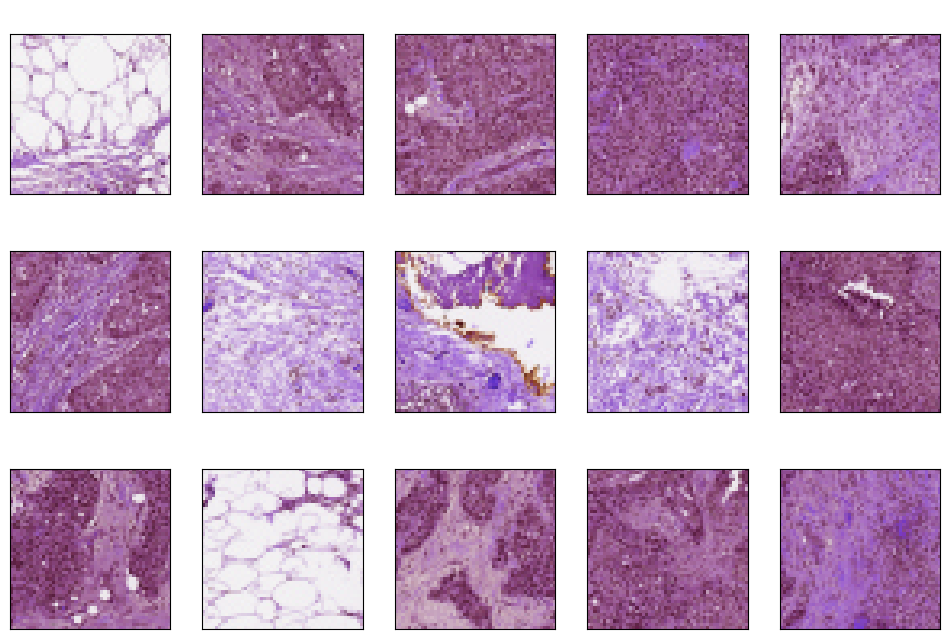

In [49]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [50]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")


train set shape: (1028, 2)
test set shape: (61, 2)
validation set shape: (115, 2)


In [51]:
train_datagen = ImageDataGenerator(rescale=1./255)  # You can add more augmentations here if needed
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [54]:


train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = val_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen =test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 1028 validated image filenames belonging to 2 classes.
Found 115 validated image filenames belonging to 2 classes.
Found 61 validated image filenames belonging to 2 classes.


In [56]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
)

base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))



x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) 
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [21]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.keras", save_best_only=True, verbose=0)
]

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

history = model.fit(train_gen, validation_data=val_gen, epochs=50, 
                    callbacks=callbacks, verbose=1)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 977ms/step - accuracy: 0.6848 - loss: 0.6003 - val_accuracy: 0.7478 - val_loss: 0.5680
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7008 - loss: 0.5697 - val_accuracy: 0.7391 - val_loss: 0.5695
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7310 - loss: 0.5414 - val_accuracy: 0.7826 - val_loss: 0.5130
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7752 - loss: 0.5068 - val_accuracy: 0.7304 - val_loss: 0.5411
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 995ms/step - accuracy: 0.7838 - loss: 0.5021 - val_accuracy: 0.7913 - val_loss: 0.5211
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7834 - loss: 0.4799 - val_accuracy: 0.8174 - val_loss: 0.4731
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 989ms/step - accuracy: 0.8101 - loss: 0.4632 - val_accuracy: 0.7652 - val_loss: 0.5048
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8185 - loss: 0.4460 - val_accuracy: 0.8435 - 

In [31]:
model.save("model.h5")

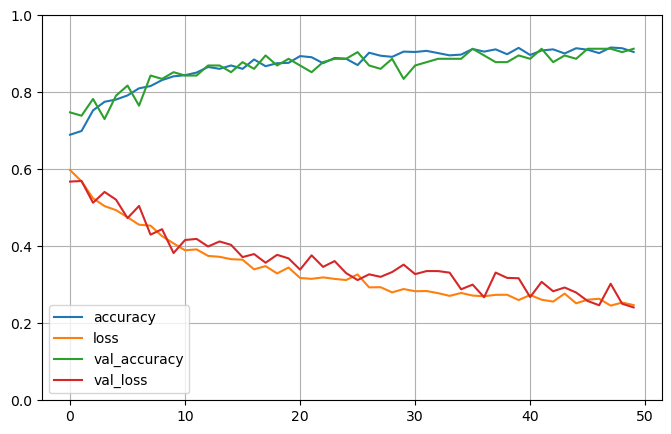

In [57]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [58]:
from PIL import Image
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import numpy as np

image = cv2.imread("8864_idx5_x1_y2251_class0.png")#actually it is no

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred >= 0.5:
  print("Yes")
else:
  print("No")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
No


<h3>answers to the questions</h3>
<li>training and testing split you used-->train_test_split 
<li>How many epochs / iterations did you run your model-->50
<li>Do you think CNN is best for images dataset or are there any algorithms that can be a better model than this ,if so please mention which ?->yeah.. CNN  is too good for image database. but I think Yolo might be better 
<li>What is the Accuracy after 5 epochs ,10 epochs--> for 5 epochs, it 0.7838 and for 10,it is 0.8362